In [1]:
#imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import time
import clip
import matplotlib.pyplot as plt
import json
import glob

from PIL import Image

In [2]:
class SparseEncoder(nn.Module):
    def __init__(self, embed_dim, vocab_size, token_embedding):
        super().__init__()
        self.sparse_projection = nn.Linear(embed_dim, vocab_size)
        self.sparse_projection.weight = nn.Parameter(token_embedding.weight)
    
    def forward(self, dense_vec):
        logits = self.sparse_projection(dense_vec)
        lex_weights = torch.log1p(torch.relu(logits))
        return lex_weights

In [3]:
class encoded_vectors():
    def __init__(self, image_vectors, caption_vectors):

        self.images = image_vectors
        self.captions  = caption_vectors

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image,caption

In [4]:
def test_sparse_performance(model, test_ims, test_cap):
    with torch.no_grad():
        x, _ = test_ims.shape
        test_ims = test_ims[0::5]
        encoded_ims = torch.empty(int(x/5), 49408).to(device)
        for i in range(0, len(encoded_ims), 64):
            encoded_ims[i:i+64] = model(test_ims[i:i+64])

        encoded_caps = torch.empty(int(x), 49408).to(device)
        for i in range(0, len(encoded_caps), 64):
            encoded_caps[i:i+64] = model(test_cap[i:i+64])   
 
        encoded_ims = (encoded_ims / encoded_ims.norm(dim=-1, keepdim=True)).to("cpu")
        encoded_caps = (encoded_caps / encoded_caps.norm(dim=-1, keepdim=True)).to("cpu")
        
        recall_1, recall_5, recall_10 = [],[],[]
        i = 0
        j = 0
        image_id = 0
        print(len(encoded_caps))
        t = time.time()
        for text_feature in encoded_caps:
            if (j%100) == 0:
                print(j, ", time since last: ", time.time() - t, end='\r')
                t = time.time()
            similarity = (100.0 * text_feature @ encoded_ims.T).softmax(dim=-1)
            _, indices = similarity.topk(10)

            recall_1.append(image_id in indices[0])
            recall_5.append(image_id in indices[:5])
            recall_10.append(image_id in indices)
    
            i += 1
            j += 1
            if i == 5:
                i = 0
                image_id += 1

        return torch.Tensor(recall_1).mean(), torch.Tensor(recall_5).mean(), torch.Tensor(recall_10).mean()                                           

In [5]:
def test_sparse_performance(model, test_ims, test_cap):
    with torch.no_grad():
        x, _ = test_ims.shape
        encoded_ims = torch.empty(int(x), 49408).to(device)
        for i in range(0, len(encoded_ims), 64):
            encoded_ims[i:i+64] = model(test_ims[i:i+64])

        encoded_caps = torch.empty(int(x*5), 49408).to(device)
        for i in range(0, len(encoded_caps), 64):
            encoded_caps[i:i+64] = model(test_cap[i:i+64])   
 
        encoded_ims = encoded_ims / encoded_ims.norm(dim=-1, keepdim=True)
        encoded_caps = encoded_caps / encoded_caps.norm(dim=-1, keepdim=True)
        
        recall_1, recall_5, recall_10 = [],[],[]
        i = 0
        j = 0
        image_id = 0
        print(len(encoded_caps))
        t = time.time()
        for text_feature in encoded_caps:
            if (j%1000) == 0:
                print(j, ", time since last: ", time.time() - t, end='\r')
                t = time.time()
            similarity = (100.0 * text_feature @ encoded_ims.T).softmax(dim=-1)
            _, indices = similarity.topk(10)

            recall_1.append(image_id in indices[0])
            recall_5.append(image_id in indices[:5])
            recall_10.append(image_id in indices)
    
            i += 1
            j += 1
            if i == 5:
                i = 0
                image_id += 1

        return torch.Tensor(recall_1).mean(), torch.Tensor(recall_5).mean(), torch.Tensor(recall_10).mean()                                           

In [6]:
def test_dense_performance(encoded_ims, encoded_caps):
    encoded_ims = encoded_ims[0::5] / encoded_ims[0::5].norm(dim=-1, keepdim=True)
    encoded_caps = encoded_caps / encoded_caps.norm(dim=-1, keepdim=True)

    recall_1 = []
    recall_5 = []
    recall_10 = []
    i = 0
    image_id = 0
    for text_feature in encoded_caps:
        similarity = (100.0 * text_feature.to(device) @ encoded_ims.T).softmax(dim=-1)

        values, indices = similarity.topk(1)
        recall_1.append(image_id in indices)

        values, indices = similarity.topk(5)
        recall_5.append(image_id in indices)

        values, indices = similarity.topk(10)
        recall_10.append(image_id in indices)

        i += 1
        if i == 5:
            i = 0
            image_id += 1

    recall_1 = torch.Tensor(recall_1)
    recall_5 = torch.Tensor(recall_5)
    recall_10 = torch.Tensor(recall_10)
    
    return recall_1.mean(), recall_5.mean(), recall_10.mean()

In [7]:
# "ViT-L/14@336px" "ViT-B/32" 

In [8]:
print(torch.cuda.memory_allocated())
model = 0
print(torch.cuda.memory_allocated())

359664128
101385216


In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32" ,device=device,jit=False)

checkpoint = torch.load("D:/thesis/Models/flickr30k trained/92.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
embed_dim = model.text_projection.shape[1]
sparse_mlm = SparseEncoder(embed_dim, model.vocab_size, model.token_embedding).to(device)

In [16]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

# load all captions
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'train']
test_caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

files = []
test_files = []
for x in data['images']:
    if x.get('split') == 'train':
        files.append('datasets/flickr30k/train/' + x['filename'])
    
    elif x.get('split') == 'test':
        test_files.append('datasets/flickr30k/test/' + x['filename'])
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
        
test_captions = []
for x in test_caps:
    for y in x:
        test_captions.append(y)
    
captions = [x.get('raw') for x in captions]
test_captions = [x.get('raw') for x in test_captions]

# these captions are too long and need adjusting
captions[13035] = 'Four young adults sit outside on a wooden deck near a building around a small round table, while another person stands on the edge of the deck, leaning on the wooden railing, with the sun shining on one of them, one holding a cellphone out in front of himself and another holding a green and red soda can.'
captions[14580] = 'A man wearing a helmet, red pants with white and a white and red shirt is on a small bicycle using only his hands, while another man wearing a light blue shirt with dark blue trim and black pants with red stripes is standing nearby, gesturing toward the first man and holding a small figurine.'
captions[120165] = 'In this photo there is a man in a dirty white shirt and a black hat with yellow stained teeth, he looks happy and it appears that he is also repairing something.'
test_captions[3905] = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'

In [8]:
files = files[0:10]
captions = captions[0:50]

In [11]:
# encode images
L = len(files)
batch_size = 32
t1 = time.time()
with torch.no_grad():
    encoded_ims = torch.Tensor()
    for i in range(0, L, batch_size):
        print(i,"/",L, torch.cuda.memory_allocated(), end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(files[i+x])).to(device)
                images = torch.cat((images, image.reshape(1,3,336,336)), 0)
                
        ims = model.encode_image(images)
        encoded_ims = torch.cat((encoded_ims, torch.repeat_interleave(ims.to("cpu"), 5, dim=0)), 0)

encoded_images = encoded_ims.to(device)
print("")
print("done")
print(time.time() - t1)

28992 / 29000 988980736
done
1681.2453961372375


In [ ]:
# vitb32, vitb32Ft, vitL14@336

In [9]:
encoded_images = torch.load("pt datafiles/flickr/encoded_images_vitb32Ft.pt")

In [10]:
encoded_images.shape

torch.Size([145000, 512])

In [12]:
torch.save(encoded_images, "encoded_images_vitL14@336.pt")

In [14]:
text = clip.tokenize(captions).to(device)

# encode captions
text_features = torch.Tensor().to(device)
with torch.no_grad():
    for i in range(0, len(text), 128):
        ts = model.encode_text(text[i:i+128])
        text_features = torch.cat((text_features, ts), 0)
        if (i%256) == 0:
            print(i,"/",len(text), end='\r')

print("")
print("done")

144896 / 145000
done


In [11]:
text_features = torch.load("pt datafiles/flickr/encoded_captions_vitb32Ft.pt")

In [12]:
text_features.shape

torch.Size([145000, 512])

In [15]:
torch.save(text_features, "encoded_captions_vitL14@336.pt")

In [17]:
# encode images
L = len(test_files)
batch_size = 32
t1 = time.time()
with torch.no_grad():
    test_ims = torch.Tensor()
    for i in range(0, L, batch_size):
        print(i,"/",L, torch.cuda.memory_allocated(), end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(test_files[i+x])).to(device)
                images = torch.cat((images, image.reshape(1,3,224,224)), 0)
                
        ims = model.encode_image(images)
        test_ims = torch.cat((test_ims, ims.to("cpu")), 0)

test_images = test_ims.to(device)
print("")
print("done")
print(time.time() - t1)

992 / 1000 985397760
done
6.27539587020874


In [13]:
test_images = torch.load("pt datafiles/flickr/test_images_vitb32Ft.pt")

In [19]:
test_images.shape

torch.Size([1000, 512])

In [18]:
torch.save(test_images, "test_images_vitb32Ft.pt")

In [26]:
text = clip.tokenize(test_captions).to(device)

# encode captions
test_features = torch.Tensor().to(device)
with torch.no_grad():
    for i in range(0, len(text), 128):
        ts = model.encode_text(text[i:i+128])
        test_features = torch.cat((test_features, ts), 0)
        if (i%256) == 0:
            print(i,"/",len(text), end='\r')

print("")
print("done")

4864 / 5000
done


In [20]:
test_features = torch.load("pt datafiles/flickr/test_captions_vitb32Ft.pt")

In [21]:
test_features.shape

torch.Size([5000, 512])

In [19]:
torch.save(test_features, "test_captions_vitL14@336.pt")

In [22]:
batchsize = 64

dataset = encoded_vectors(encoded_images, text_features)
train_dataloader = DataLoader(dataset, batch_size = batchsize, shuffle=True)

In [23]:
#before training
rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, test_images, test_features)
print(rec1)
print(rec5)
print(rec10)

5000
tensor(0.5302)nce last:  0.9143605232238772
tensor(0.7908)
tensor(0.8626)


loss: 757.94170853123072265
5000
R@1: tensor(0.5934)ast:  0.9087588787078857

loss: 519.247769869864 2265
5000
R@1: tensor(0.5816)ast:  0.9207675457000732

loss: 346.55492580309512265
5000
R@1: tensor(0.5964)ast:  0.9252562522888184

loss: 314.50334586482495265
5000
R@1: tensor(0.5912)ast:  0.9593751430511475

loss: 291.91045474354182265
5000
R@1: tensor(0.5908)ast:  0.8997485637664795

loss: 269.31393012590706265
5000
R@1: tensor(0.5930)ast:  0.9057459831237793

loss: 268.77857599034905265
5000
R@1: tensor(0.5926)ast:  0.9002456665039062

loss: 269.68633797485382265
5000
R@1: tensor(0.5926)ast:  0.9010930061340332

loss: 265.61915476713332265
5000
R@1: tensor(0.5922)ast:  0.9012835025787354

loss: 265.87353944778442265
5000
R@1: tensor(0.5920)ast:  0.9253442287445068


done


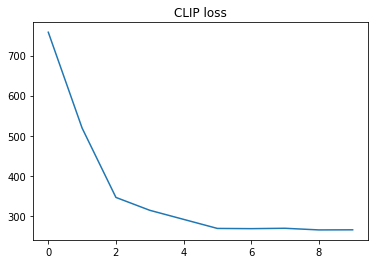

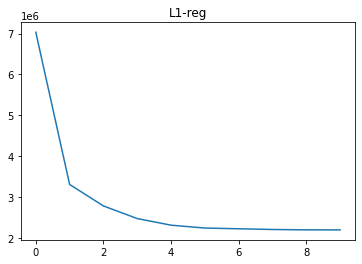

In [24]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sparse_mlm.parameters(), lr=1e-4,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,5,8], gamma=0.1)

epochs = 10
totalbatches = int(len(dataset) / batchsize)
logit_scale = 100 #model.logit_scale.exp().item()
alpha = 1
lambda1 = 0.0001
cliplosses = []
sparselosses = []
test_loss=[[rec1],[rec5],[rec10]]
for epoch in range(0, epochs):
    i = 0
    cliploss_total = 0
    sparseloss_total = 0
    for batch in train_dataloader:
        if i % 25 == 0:
            print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        ims, caps = batch
        
        # sparse encoding
        sparse_ims = sparse_mlm(ims)
        sparse_caps = sparse_mlm(caps)
        
        l1_regularization = torch.norm(sparse_ims, 1) + torch.norm(sparse_caps, 1)

        # determine logits
        sparse_ims = sparse_ims / sparse_ims.norm(dim=-1, keepdim=True)
        sparse_caps = sparse_caps / sparse_caps.norm(dim=-1, keepdim=True)
        logits_per_image = logit_scale * sparse_ims @ sparse_caps.t()
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(ims),dtype=torch.long,device=device)
        
        clip_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss = alpha * clip_loss + lambda1 * l1_regularization
        
        cliploss_total += clip_loss.item()
        sparseloss_total += l1_regularization.item()
    
        total_loss.backward()

        optimizer.step()
        i+=1
        
    scheduler.step()    
    cliplosses.append(cliploss_total)
    sparselosses.append(sparseloss_total)
    print("loss:", cliploss_total)
    
    rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, test_images, test_features)
    test_loss[0].append(rec1)
    test_loss[1].append(rec5)
    test_loss[2].append(rec10)
    print("R@1:", rec1)
    print("")
"""
    torch.save({
        'epoch':epoch,
        'model_state_dict': sparse_mlm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"Models/" + str(epoch) + ".pt")
"""      
print("")
print("done")

plt.plot(cliplosses)
plt.title('CLIP loss')
plt.show()

plt.plot(sparselosses)
plt.title('L1-reg')
plt.show()

In [25]:
test_loss

[[tensor(0.5302),
  tensor(0.5934),
  tensor(0.5816),
  tensor(0.5964),
  tensor(0.5912),
  tensor(0.5908),
  tensor(0.5930),
  tensor(0.5926),
  tensor(0.5926),
  tensor(0.5922),
  tensor(0.5920)],
 [tensor(0.7908),
  tensor(0.8498),
  tensor(0.8554),
  tensor(0.8638),
  tensor(0.8622),
  tensor(0.8592),
  tensor(0.8584),
  tensor(0.8598),
  tensor(0.8602),
  tensor(0.8598),
  tensor(0.8592)],
 [tensor(0.8626),
  tensor(0.9102),
  tensor(0.9176),
  tensor(0.9204),
  tensor(0.9210),
  tensor(0.9204),
  tensor(0.9200),
  tensor(0.9208),
  tensor(0.9210),
  tensor(0.9206),
  tensor(0.9206)]]

In [26]:
with torch.no_grad():
    total_nonzero = 0
    i = 0
    for image in test_images:
        sparse = sparse_mlm(image)
        total_nonzero += (len(sparse) - torch.count_nonzero(sparse))/len(sparse)
        i += 1
        
    for caption in test_features:
        sparse = sparse_mlm(caption)
        total_nonzero += (len(sparse) - torch.count_nonzero(sparse))/len(sparse)
        i += 1
        
    print(total_nonzero/i)

tensor(0.9973, device='cuda:0')


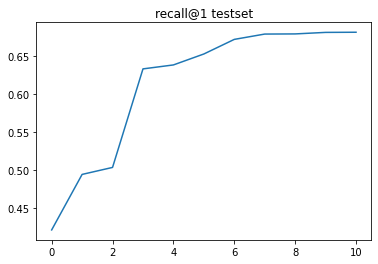

In [28]:
plt.plot(test_loss[0])
plt.title('recall@1 testset')
plt.show()

In [32]:
#open the json file for annotations
f = open("C:/Users/Lalashops/Desktop/MasterThesis/random images/vocab.json", encoding = 'utf-8')
vocab = json.load(f)

In [33]:
sparse_cap = sparse_mlm(test_images[0])

In [34]:
for idx in torch.topk(sparse_cap, 10).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_cap[idx])

reflected</w> tensor(0.5257, device='cuda:0', grad_fn=<SelectBackward0>)
amphibious</w> tensor(0.4498, device='cuda:0', grad_fn=<SelectBackward0>)
floating</w> tensor(0.2255, device='cuda:0', grad_fn=<SelectBackward0>)
minded</w> tensor(0.2152, device='cuda:0', grad_fn=<SelectBackward0>)
macedonia</w> tensor(0.1916, device='cuda:0', grad_fn=<SelectBackward0>)
peterson</w> tensor(0.1734, device='cuda:0', grad_fn=<SelectBackward0>)
shaq</w> tensor(0.1689, device='cuda:0', grad_fn=<SelectBackward0>)
manipu tensor(0.1620, device='cuda:0', grad_fn=<SelectBackward0>)
that tensor(0.1543, device='cuda:0', grad_fn=<SelectBackward0>)
geon</w> tensor(0.1481, device='cuda:0', grad_fn=<SelectBackward0>)
